In [42]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve,\
davies_bouldin_score as dbs, normalized_mutual_info_score as nmi, adjusted_rand_score as ars
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import log_loss
from sklearn import model_selection, metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from sklearn.cluster import KMeans
from typing import Tuple
import pandas as pd
import itertools
import numpy as np
import argparse
import random
import umap
import sys
import umap
from CAC import CAC

In [17]:
DATASET = ["magic", "diabetes"]
classifier = ['LR', 'Perceptron']
color = color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

In [92]:
def get_classifier(classifier):
    if classifier == "LR":
        model = LogisticRegression(random_state=0, max_iter=1000)
    elif classifier == "RF":
        model = RandomForestClassifier(n_estimators=10)
    elif classifier == "SVM":
        # model = SVC(kernel="linear", probability=True)
        model = LinearSVC(max_iter=5000)
        model.predict_proba = lambda X: np.array([model.decision_function(X), model.decision_function(X)]).transpose()
    elif classifier == "Perceptron":
        model = Perceptron()
        model.predict_proba = lambda X: np.array([model.decision_function(X), model.decision_function(X)]).transpose()
    elif classifier == "ADB":
        model = AdaBoostClassifier(n_estimators = 100)
    elif classifier == "DT":
        model = DecisionTreeClassifier()
    elif classifier == "LDA":
        model = LDA()
    elif classifier == "NB":
        model = MultinomialNB()
    elif classifier == "SGD":
        model = SGDClassifier(loss='log')
    elif classifier == "Ridge":
        model = RidgeClassifier()
        model.predict_proba = lambda X: np.array([model.decision_function(X), model.decision_function(X)]).transpose()
    elif classifier == "KNN":
        model = KNeighborsClassifier(n_neighbors=5)
    else:
        model = LogisticRegression(class_weight='balanced', max_iter=1000)
    return model

def get_dataset(DATASET):
	if DATASET == "cic":
	    Xa = pd.read_csv("./data/CIC/cic_set_a.csv")
	    Xb = pd.read_csv("./data/CIC/cic_set_b.csv")
	    Xc = pd.read_csv("./data/CIC/cic_set_c.csv")

	    ya = Xa['In-hospital_death']
	    yb = Xb['In-hospital_death']
	    yc = Xc['In-hospital_death']

	    Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
	    Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
	    Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

	    cols = Xa.columns

	    scale = StandardScaler()
	    Xa = scale.fit_transform(Xa)
	    Xb = scale.fit_transform(Xb)
	    Xc = scale.fit_transform(Xc)

	    Xa = pd.DataFrame(Xa, columns=cols)
	    Xb = pd.DataFrame(Xb, columns=cols)
	    Xc = pd.DataFrame(Xc, columns=cols)

	    Xa = Xa.fillna(0)
	    Xb = Xb.fillna(0)
	    Xc = Xc.fillna(0)

	    X_train = pd.concat([Xa, Xb])
	    y_train = pd.concat([ya, yb])

	    X_test = Xc
	    y_test = yc

	    X = pd.concat([X_train, X_test]).to_numpy()
	    y = pd.concat([y_train, y_test]).to_numpy()

	elif DATASET == "titanic":
	    X_train = pd.read_csv("./data/" + DATASET + "/" + "X_train.csv").to_numpy()
	    X_test = pd.read_csv("./data/" + DATASET + "/" + "X_test.csv").to_numpy()
	    y_train = pd.read_csv("./data/" + DATASET + "/" + "y_train.csv").to_numpy()
	    y_test = pd.read_csv("./data/" + DATASET + "/" + "y_test.csv").to_numpy()

	    X = np.vstack([X_train, X_test])
	    y = np.vstack([y_train, y_test])
	    # X = pd.concat([X_train, X_test]).to_numpy()
	    # y = pd.concat([y_train, y_test]).to_numpy()

	else:
	    X = pd.read_csv("./data/" + DATASET + "/" + "X.csv").to_numpy()
	    y = pd.read_csv("./data/" + DATASET + "/" + "y.csv").to_numpy()

	y1 = []
	for i in range(len(y)):
		y1.append(y[i][0])
	y = np.array(y1)
	return X, y

def print_scores(X_test, y_test, cac):
    y_pred, y_proba = cac.predict(X_test, -1)

    cac_f1 = f1_score(y_pred, y_test)
    cac_auc = roc_auc_score(y_test, y_proba)

    print("CAC confusion matrix")
    print(confusion_matrix(y_test, y_pred))

    y_pred, y_proba = cac.predict(X_test, 0)
    km_f1 = f1_score(y_pred, y_test)
    km_auc = roc_auc_score(y_test, y_proba)

    print("KM confusion matrix")
    print(confusion_matrix(y_test, y_pred))

    clf = get_classifier(cac.classifier)
    clf.fit(X_train, y_train.ravel())
    y_pred = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)

    base_f1 = f1_score(y_pred, y_test)
    base_auc = roc_auc_score(y_test.ravel(), pred_proba[:,1])

    print("Base classifier confusion matrix")
    print(confusion_matrix(y_test, y_pred))
    
    print("5-Fold terminal CAC scores", base_f1, base_auc)
    print("5-Fold KMeans scores", km_f1, km_auc)
    print("5-Fold Base scores", cac_f1, cac_auc)
    return None


## Load the Diabetes Dataset

In [11]:
X, y = get_dataset(DATASET[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=108) 
scale = StandardScaler()
X_train = scale.fit_transform(X_train) 
X_test = scale.fit_transform(X_test)
reducer = umap.UMAP()

X1 = reducer.fit_transform(X_train)

### alpha = 2.5, classifier = Perceptron

In [21]:
dbts = CAC(2, 2.5, classifier="Perceptron")
dbts.fit(X_train, y_train)

### Plotting the training class distribution

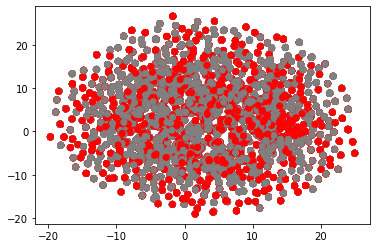

In [25]:
# True Distribution
c = [color[int(y_train[i])] for i in range(len(y_train))]
plt.scatter(X1[:,0], X1[:,1], color=c); plt.show()

### Plotting k-means clusters

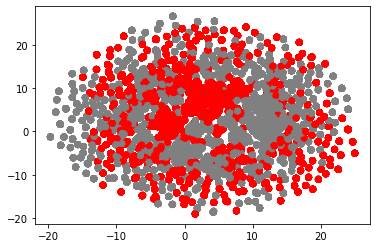

In [23]:
c = [color[int(dbts.labels[0][i])] for i in range(len(y_train))]
plt.scatter(X1[:,0], X1[:,1], color=c); plt.show()

### Plotting CAC clusters

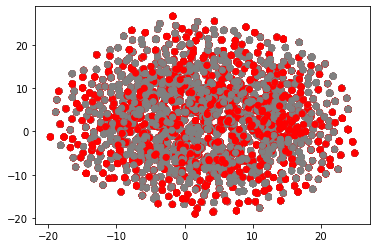

In [24]:
c = [color[int(dbts.labels[-1][i])] for i in range(len(y_train))]
plt.scatter(X1[:,0], X1[:,1], color=c); plt.show()

### Is CAC overfitting?

Check Rand index of cluster labels and the training labels at every iteration

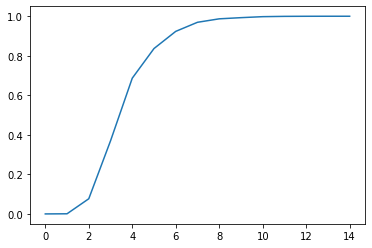

In [32]:
vals = []
for i in range(len(dbts.labels)):
    vals.append(ars(y_train, dbts.labels[i]))
plt.plot(vals)
plt.show()

The rand index approaches 1 => it is indeed overfitting

## Magic Dataset

In [65]:
X, y = get_dataset(DATASET[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=108) 
scale = StandardScaler()
X_train = scale.fit_transform(X_train) 
X_test = scale.fit_transform(X_test)

In [35]:
X2 = reducer.fit_transform(X_train)

In [71]:
magic = CAC(2, 0.05, classifier="Perceptron")
magic.fit(X_train, y_train)

### Same 3 plots as above

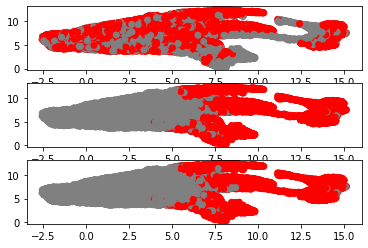

In [72]:
gs = gridspec.GridSpec(3,1)

pl.figure()
ax = pl.subplot(gs[0])
c = [color[int(y_train[i])] for i in range(len(y_train))]
pl.scatter(X2[:,0], X2[:,1], color=c)
# pl.plot([0,1])

ax = pl.subplot(gs[1])
c = [color[int(magic.labels[0][i])] for i in range(len(y_train))]
pl.scatter(X2[:,0], X2[:,1], color=c)

ax = pl.subplot(gs[2])
c = [color[int(magic.labels[-1][i])] for i in range(len(y_train))]
plt.scatter(X2[:,0], X2[:,1], color=c); plt.show()

### Check overfitting

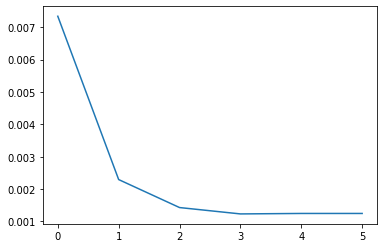

In [74]:
# Overfitting?
vals = []
for i in range(len(magic.labels)):
    vals.append(ars(y_train, magic.labels[i]))
plt.plot(vals)
plt.show()

## Adult Dataset

In [76]:
X, y = get_dataset("adult")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=108) 
scale = StandardScaler()
X_train = scale.fit_transform(X_train) 
X_test = scale.fit_transform(X_test)

In [79]:
X3 = reducer.fit_transform(X_train)

In [78]:
adult = CAC(2, 0.15, classifier="Perceptron")
adult.fit(X_train, y_train)

### Same 3 plots as above

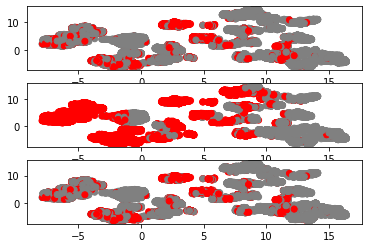

In [81]:
gs = gridspec.GridSpec(3,1)

pl.figure()
ax = pl.subplot(gs[0])
c = [color[int(y_train[i])] for i in range(len(y_train))]
pl.scatter(X3[:,0], X3[:,1], color=c)
# pl.plot([0,1])

ax = pl.subplot(gs[1])
c = [color[int(adult.labels[0][i])] for i in range(len(y_train))]
pl.scatter(X3[:,0], X3[:,1], color=c)

ax = pl.subplot(gs[2])
c = [color[int(adult.labels[-1][i])] for i in range(len(y_train))]
pl.scatter(X3[:,0], X3[:,1], color=c); pl.show()

### Check overfitting

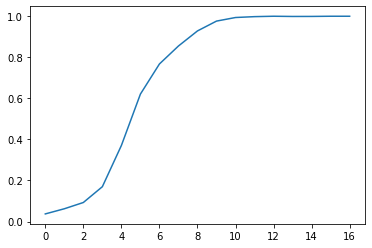

In [83]:
# Overfitting?
vals = []
for i in range(len(adult.labels)):
    vals.append(ars(y_train, adult.labels[i]))
plt.plot(vals)
plt.show()

In [93]:
print_scores(X_test, y_test, adult)
# print(adult)

CAC confusion matrix
[[4658 1523]
 [ 396 1564]]
KM confusion matrix
[[5976  205]
 [1416  544]]
Base classifier confusion matrix
[[5345  836]
 [1072  888]]
5-Fold terminal CAC scores 0.4820846905537459 0.7922073569761183
5-Fold KMeans scores 0.401624215577704 0.7818981143662772
5-Fold Base scores 0.6197741232415296 0.8060566614608957


In [76]:
X, y = get_dataset("adult")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=108) 
scale = StandardScaler()
X_train = scale.fit_transform(X_train) 
X_test = scale.fit_transform(X_test)

In [79]:
X3 = reducer.fit_transform(X_train)

In [78]:
adult = CAC(2, 0.15, classifier="Perceptron")
adult.fit(X_train, y_train)

### Same 3 plots as above

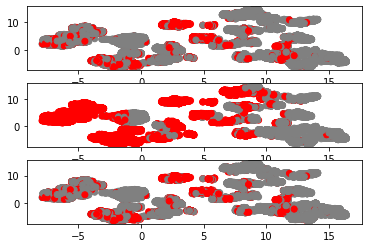

In [81]:
gs = gridspec.GridSpec(3,1)

pl.figure()
ax = pl.subplot(gs[0])
c = [color[int(y_train[i])] for i in range(len(y_train))]
pl.scatter(X3[:,0], X3[:,1], color=c)
# pl.plot([0,1])

ax = pl.subplot(gs[1])
c = [color[int(adult.labels[0][i])] for i in range(len(y_train))]
pl.scatter(X3[:,0], X3[:,1], color=c)

ax = pl.subplot(gs[2])
c = [color[int(adult.labels[-1][i])] for i in range(len(y_train))]
pl.scatter(X3[:,0], X3[:,1], color=c); pl.show()

### Check overfitting

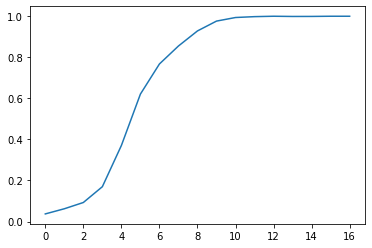

In [83]:
# Overfitting?
vals = []
for i in range(len(adult.labels)):
    vals.append(ars(y_train, adult.labels[i]))
plt.plot(vals)
plt.show()

In [93]:
print_scores(X_test, y_test, adult)
# print(adult)

CAC confusion matrix
[[4658 1523]
 [ 396 1564]]
KM confusion matrix
[[5976  205]
 [1416  544]]
Base classifier confusion matrix
[[5345  836]
 [1072  888]]
5-Fold terminal CAC scores 0.4820846905537459 0.7922073569761183
5-Fold KMeans scores 0.401624215577704 0.7818981143662772
5-Fold Base scores 0.6197741232415296 0.8060566614608957


## Creditcard Dataset

In [94]:
X, y = get_dataset("creditcard")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=108) 
scale = StandardScaler()
X_train = scale.fit_transform(X_train) 
X_test = scale.fit_transform(X_test)

In [98]:
X3 = reducer.fit_transform(X_train)

In [97]:
credit = CAC(3, 0.2, classifier="Perceptron")
credit.fit(X_train, y_train)

### Same 3 plots as above

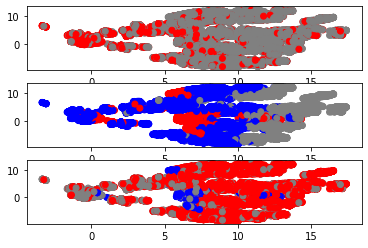

In [99]:
gs = gridspec.GridSpec(3,1)

pl.figure()
ax = pl.subplot(gs[0])
c = [color[int(y_train[i])] for i in range(len(y_train))]
pl.scatter(X3[:,0], X3[:,1], color=c)
# pl.plot([0,1])

ax = pl.subplot(gs[1])
c = [color[int(adult.labels[0][i])] for i in range(len(y_train))]
pl.scatter(X3[:,0], X3[:,1], color=c)

ax = pl.subplot(gs[2])
c = [color[int(adult.labels[-1][i])] for i in range(len(y_train))]
pl.scatter(X3[:,0], X3[:,1], color=c); pl.show()

### Check overfitting

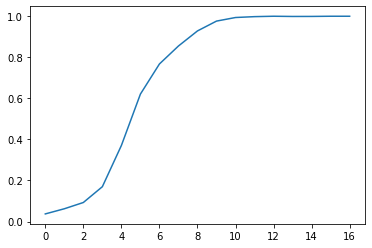

In [83]:
# Overfitting?
vals = []
for i in range(len(adult.labels)):
    vals.append(ars(y_train, adult.labels[i]))
plt.plot(vals)
plt.show()

In [93]:
print_scores(X_test, y_test, adult)
# print(adult)

CAC confusion matrix
[[4658 1523]
 [ 396 1564]]
KM confusion matrix
[[5976  205]
 [1416  544]]
Base classifier confusion matrix
[[5345  836]
 [1072  888]]
5-Fold terminal CAC scores 0.4820846905537459 0.7922073569761183
5-Fold KMeans scores 0.401624215577704 0.7818981143662772
5-Fold Base scores 0.6197741232415296 0.8060566614608957
